In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd
import re
plt.rc('font', family='Times New Roman') # 设置latex字体

In [20]:
class GrayCode: # 返回n位格雷码的list
    def __init__(self):
        self.base = ["0", "1"]

    def getNext(self , prelist, z_or_one):
        output = []
        for code in prelist:
            new_code = "%s%s" % (z_or_one, code)
            output.append(new_code)
        if z_or_one == 1:
            output.reverse()
        return output

    def gray(self):
        haf1 = self.getNext(self.base, 0)
        haf2 = self.getNext(self.base, 1)
        ret = haf1 + haf2
        self.base = ret 

    def  getGray(self, n):
        for i in range(n - 1):
            self.gray()
        return self.base

class KCC:
    def __init__(self, instance_name, symmetric):
        self.instance_name = instance_name
        self.symmetric = symmetric
        self.pf_file_name = instance_name
        # Read the pf file
        self.pf = np.loadtxt(self.pf_file_name)
        print (self.pf.shape)
        self.SOL_NUM = self.pf.shape[0]
        self.OBJ_NUM = self.pf.shape[1]
        self.nor_pf_file_name = instance_name
        self.nor_pf = np.loadtxt(self.nor_pf_file_name)
        ################################
        # 根据对称还是非对称，提取算例名
        if self.symmetric is False:
            self.csv_name = self.instance_name.replace('result/as/MOEAD/MOEAD_GLS/', '').replace('/PF/pf', '')
        else:
            self.csv_name = self.instance_name.replace('result/s/MOEAD/MOEAD_GLS/', '').replace('/PF/pf', '')
        ################################
        
    # Step 1-Global pairwise relationsips analysis        
    def analyze_KCC_2(self):
        df = pd.DataFrame(self.pf)
        result = df.corr('kendall')
        x = []
        y = []
        z_line = []
        up = []
        down = []
        for i in range(0, self.OBJ_NUM):
            for j  in range(i + 1, self.OBJ_NUM):
                res = result[i][j]
                s = '$f_{' + str(i + 1) + '}-f_{' + str(j + 1) + '}$'
                x.append(s)
                y.append(res)
                z_line.append(0)
                up.append(0.5)
                down.append(-0.5)
        data = pd.DataFrame({'obj':x, 'res':y, 'zero':z_line, 'up':up, 'down':down})
        print ("INSTANCE: ", self.csv_name)
        data.to_csv('kendall/' + self.csv_name + '-kendall.csv', index=False)
        
    # Step 2-Objective range analysis            
    def analyze_obj_range(self):
        obj_list = []
        min_list = []
        max_list = []
        average_list = []
        for i in range(self.OBJ_NUM):
            _min = 1e10
            _max = -1
            _sum = 0
            for j in range(self.SOL_NUM):
                if self.pf[j][i] < _min:
                    _min = self.pf[j][i]
                if self.pf[j][i] > _max:
                    _max = self.pf[j][i]
                _sum += self.pf[j][i]
            obj_list.append('$f_' + str(i + 1) + '$')
            min_list.append(_min)
            max_list.append(_max)
            average_list.append(_sum / self.SOL_NUM)
        data = pd.DataFrame({'obj':obj_list, 'min':min_list, 'max':max_list, 'average':average_list})
        data.to_csv('range/' + self.csv_name + '-range.csv', index=False)
    
    def analyze_threshold(self):
        alpha = 20 # divide the range into alpha parts with equal range
        interval = 1.0 / alpha
        threshold_list = []
        r_zero_list = []
        for i in range(alpha + 1):
            threshold = i * interval
            threshold = round(threshold, 2)
            threshold_list.append(threshold)
            r_zero = self.region(threshold)
            r_zero_percentage = r_zero / self.nor_pf.shape[0]
            r_zero_list.append(r_zero_percentage)
        data = pd.DataFrame({'threshold':threshold_list, 'r_zero':r_zero_list})
        data.to_csv('threshold/' + self.csv_name + '-threshold.csv', index=False)
    
    def region(self, threshold):
        a = GrayCode()
        region_list = a.getGray(self.OBJ_NUM)
        region_dict = {}
        for i in range(len(region_list)):
            region_dict[region_list[i]] = 0
        for i in range(self.SOL_NUM):
            my_code = ''
            for j in range(self.OBJ_NUM):
                if self.nor_pf[i][j] <= threshold: # better: 0
                    my_code += '0'
                else:
                    my_code += '1' # worse
            region_dict[my_code] = region_dict[my_code] + 1
        sol_num = []
        for i in range(len(region_list)):
            sol_num.append(region_dict[region_list[i]] / self.SOL_NUM)
        region_list = np.reshape(region_list, (8, 8))
        sol_num = np.reshape(sol_num, (8, 8))
        for i in range(8):
            if i % 2 == 1:
                region_list[i] = region_list[i][::-1]
                sol_num[i] = sol_num[i][::-1]
        # print (region_list)
        # print (sol_num)
        data = pd.DataFrame(sol_num)
        data.to_csv(self.instance_name + '-' + str(threshold) + '-3.csv', index=False)
        gray_list = []
        for i in range(8):
            for j in range(8):
                count = 0
                for k in range(self.OBJ_NUM):
                    if region_list[i][j][k] == '0':
                        count = count + 1
                gray_list.append(count)
        gray_list = np.reshape(gray_list, (8, 8))
        data = pd.DataFrame(gray_list)
        data.to_csv('region_map.csv', header=False, index=False)
        return region_dict['000000']
    
    def scatter_plot(self):
        base = 2 # 以第三个目标为横坐标
        x = self.nor_pf[:, base]
        color = ['blue', 'red', 'black', 'green', 'purple', 'orange']
        l = []
        labels = []
        for i in range(self.OBJ_NUM):
            if i != base:
                l_t = plt.scatter(x, self.nor_pf[:, i], s=3, c=color[i])
                l.append(l_t)
                labels.append('$f_'+ str(i + 1) + '$')
        plt.legend(handles=l, labels=labels, loc='best')
        plt.xlabel('$f_' + str(base + 1) + '$')
        if self.symmetric is False:
            csv_name = self.instance_name.replace('result/as/MOEAD/MOEAD_GLS/', '').replace('/PF/pf', '')
        else:
            csv_name = self.instance_name.replace('result/s/MOEAD/MOEAD_GLS/', '').replace('/PF/pf', '')
        # plt.savefig(csv_name + '-scatter.png')
        plt.savefig(csv_name + '-scatter.eps', format='eps')
        plt.show()        

In [14]:
# 第一步：全局成对关系分析（分析kendall相关系数）
# instance_name表示pf文件所在路径
instance_name = [] 
instance_name.append('result/as/MOEAD/MOEAD_GLS/test50-0-0-0-0.d0.tw0.D4/PF/pf')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test50-0-0-0-0.d0.tw0.D6/PF/pf')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test50-0-0-0-0.d0.tw1.D4/PF/pf')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test50-0-0-0-0.d0.tw1.D6/PF/pf')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test50-0-0-0-0.d0.tw2.D4/PF/pf')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test50-0-0-0-0.d0.tw2.D6/PF/pf')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test50-0-0-0-0.d0.tw3.D4/PF/pf')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test50-0-0-0-0.d0.tw3.D6/PF/pf')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test50-0-0-0-0.d0.tw4.D4/PF/pf')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test50-0-0-0-0.d0.tw4.D6/PF/pf')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test150-0-0-0-0.d0.tw0.D4/PF/pf')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test150-0-0-0-0.d0.tw0.D6/PF/pf')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test150-0-0-0-0.d0.tw1.D4/PF/pf')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test150-0-0-0-0.d0.tw1.D6/PF/pf')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test150-0-0-0-0.d0.tw2.D4/PF/pf')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test150-0-0-0-0.d0.tw2.D6/PF/pf')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test150-0-0-0-0.d0.tw3.D4/PF/pf')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test150-0-0-0-0.d0.tw3.D6/PF/pf')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test150-0-0-0-0.d0.tw4.D4/PF/pf')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test150-0-0-0-0.d0.tw4.D6/PF/pf')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test250-0-0-0-0.d0.tw0.D4/PF/pf')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test250-0-0-0-0.d0.tw0.D6/PF/pf')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test250-0-0-0-0.d0.tw1.D4/PF/pf')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test250-0-0-0-0.d0.tw1.D6/PF/pf')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test250-0-0-0-0.d0.tw2.D4/PF/pf')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test250-0-0-0-0.d0.tw2.D6/PF/pf')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test250-0-0-0-0.d0.tw3.D4/PF/pf')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test250-0-0-0-0.d0.tw3.D6/PF/pf')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test250-0-0-0-0.d0.tw4.D4/PF/pf')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test250-0-0-0-0.d0.tw4.D6/PF/pf')

instance_name.append('result/s/MOEAD/MOEAD_GLS/C101_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/C102_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/C103_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/C104_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/C105_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/C106_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/C107_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/C108_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/C109_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/C201_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/C202_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/C203_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/C204_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/C205_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/C206_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/C207_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/C208_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R101_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R102_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R103_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R104_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R105_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R106_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R107_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R108_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R109_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R110_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R111_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R112_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R201_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R202_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R203_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R204_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R205_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R206_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R207_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R208_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R209_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R210_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R211_100/PF/pf')

instance_name.append('result/s/MOEAD/MOEAD_GLS/RC101_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/RC102_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/RC103_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/RC104_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/RC105_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/RC106_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/RC107_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/RC108_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/RC201_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/RC202_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/RC203_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/RC204_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/RC205_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/RC206_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/RC207_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/RC208_100/PF/pf')

for i in range(86):
    if i < 30: # 一共有30个非对称算例
        kcc = KCC(instance_name[i], False)
    else:
        kcc = KCC(instance_name[i], True)
    kcc.analyze_KCC_2()
    
# kendall文件下会输出算例名-kendall.csv文件

(832, 6)
INSTANCE:  test50-0-0-0-0.d0.tw0.D4
(1473, 6)
INSTANCE:  test50-0-0-0-0.d0.tw0.D6
(4842, 6)
INSTANCE:  test50-0-0-0-0.d0.tw1.D4
(4100, 6)
INSTANCE:  test50-0-0-0-0.d0.tw1.D6
(6448, 6)
INSTANCE:  test50-0-0-0-0.d0.tw2.D4
(6053, 6)
INSTANCE:  test50-0-0-0-0.d0.tw2.D6
(8471, 6)
INSTANCE:  test50-0-0-0-0.d0.tw3.D4
(8941, 6)
INSTANCE:  test50-0-0-0-0.d0.tw3.D6
(5352, 6)
INSTANCE:  test50-0-0-0-0.d0.tw4.D4
(5190, 6)
INSTANCE:  test50-0-0-0-0.d0.tw4.D6
(513, 6)
INSTANCE:  test150-0-0-0-0.d0.tw0.D4
(496, 6)
INSTANCE:  test150-0-0-0-0.d0.tw0.D6
(3198, 6)
INSTANCE:  test150-0-0-0-0.d0.tw1.D4
(2625, 6)
INSTANCE:  test150-0-0-0-0.d0.tw1.D6
(3980, 6)
INSTANCE:  test150-0-0-0-0.d0.tw2.D4
(2712, 6)
INSTANCE:  test150-0-0-0-0.d0.tw2.D6
(4416, 6)
INSTANCE:  test150-0-0-0-0.d0.tw3.D4
(3444, 6)
INSTANCE:  test150-0-0-0-0.d0.tw3.D6
(3532, 6)
INSTANCE:  test150-0-0-0-0.d0.tw4.D4
(3809, 6)
INSTANCE:  test150-0-0-0-0.d0.tw4.D6
(748, 6)
INSTANCE:  test250-0-0-0-0.d0.tw0.D4
(1007, 6)
INSTANCE:  test25

In [5]:
# 第二步：目标值范围分析
# 要求这里的pf是没有归一化的
# range文件夹下输出-rang.csv文件
ins = 'result/as/MOEAD/MOEAD_GLS/test150-0-0-0-0.d0.tw4.D6/PF/pf'
kcc = KCC(ins, False)
kcc.analyze_obj_range()
ins = 'result/as/MOEAD/MOEAD_GLS/test250-0-0-0-0.d0.tw4.D6/PF/pf'
kcc = KCC(ins, False)
kcc.analyze_obj_range()
ins = 'result/s/MOEAD/MOEAD_GLS/C204_100/PF/pf'
kcc = KCC(ins, True)
kcc.analyze_obj_range()
ins = 'result/s/MOEAD/MOEAD_GLS/R101_100/PF/pf'
kcc = KCC(ins, True)
kcc.analyze_obj_range()

(3809, 6)
(2968, 6)
(1541, 6)
(5025, 6)


D:\Yuyan\My-Software\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


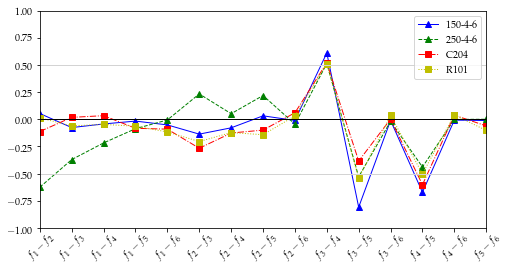

In [15]:
# Step 1: kendall画图
num = 4
instance_name = []
################################
# 以下instance_name为kendall.csv文件
instance_name.append('kendall/test150-0-0-0-0.d0.tw4.D6-kendall.csv')
instance_name.append('kendall/test250-0-0-0-0.d0.tw4.D6-kendall.csv')
instance_name.append('kendall/C204_100-kendall.csv')
instance_name.append('kendall/R101_100-kendall.csv')
################################
linestyle_list = ['-', '--', '-.', ':']
marker_list = ['^', '^', 's', 's']
l_list = []
################################
# 以下为图上的图例名
labels_list = ['150-4-6', '250-4-6', 'C204', 'R101']
################################
color_list = ['b', 'g', 'r', 'y', 'm', 'c', 'k', 'lime', 'orange', 'greenyellow', 'darkmagenta', 'moccasin']
plt.figure(figsize=(8, 4))
for i in range(num):
    data = pd.read_csv(instance_name[i])
    x = data.iloc[:, 0]
    y = data.iloc[:, 1]
    l, = plt.plot(x, y, color_list[i], linestyle=linestyle_list[i%4], marker = marker_list[i%4], linewidth=1)
    l_list.append(l)
    zero = data.iloc[:, 2]
    up = data.iloc[:, 3]
    down = data.iloc[:, 4]
    l, = plt.plot(x, zero, 'black', linewidth=1)
    lup = plt.plot(x, up, 'lightgray', linewidth=1)
    ldown = plt.plot(x, down, 'lightgray', linewidth=1)
plt.ylim(-1, 1)
plt.xlim('$f_{1}-f_{2}$', '$f_{5}-f_{6}$')
plt.xticks(rotation=45)
plt.legend(handles=l_list, labels=labels_list, loc='best')
plt.savefig('Step-1-All.eps', format='eps', dpi=1000)
plt.show()

In [16]:
# Step 2: Plot
################################
# 需要画哪个算例就改instance_name为算例名
# instance_name = 'test150-0-0-0-0.d0.tw4.D6'
# instance_name = 'test250-0-0-0-0.d0.tw4.D6'
# instance_name = 'C204_100'
instance_name = 'R101_100'
################################
data = pd.read_csv('range/' + instance_name + '-range.csv')
x = data.iloc[:, 0]
OBJ_NUM = data.shape[0]
average_pct = data.iloc[:, 3] / data.iloc[:, 2] * 100
min_pct = data.iloc[:, 1] / data.iloc[:, 2] * 100
max_pct = data.iloc[:, 2] / data.iloc[:, 2] * 100
print (data.iloc[:, 1])
fmt = '%.2f\%%' # %需要转义符
yticks = mtick.FormatStrFormatter(fmt)
plt.gca().yaxis.set_major_formatter(yticks)
plt.plot(x, average_pct, 'bo')
for i in range(OBJ_NUM):
    plt.plot([x[i], x[i]], [min_pct[i], max_pct[i]])
plt.title(instance_name)
# plt.savefig(instance_name + '-step2.png')
plt.savefig(instance_name + '-step2.eps', format='eps', dpi=1000)
plt.show()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
Name: min, dtype: float64


RuntimeError: latex was not able to process the following string:
b'R101_100'

Here is the full report generated by latex:
This is pdfTeX, Version 3.1415926-2.3-1.40.12 (MiKTeX 2.9)
entering extended mode
(C:/Users/tser/.matplotlib/tex.cache/16dfada41fdc9ecac49360b42280baa1.tex
LaTeX2e <2011/06/27>
Babel <v3.8m> and hyphenation patterns for loaded.
(C:\CTEX\MiKTeX\tex\latex\base\article.cls
Document Class: article 2007/10/19 v1.4h Standard LaTeX document class
(C:\CTEX\MiKTeX\tex\latex\base\size10.clo))
(C:\CTEX\MiKTeX\tex\latex\type1cm\type1cm.sty)
(C:\CTEX\MiKTeX\tex\latex\psnfss\mathpazo.sty)
(C:\CTEX\MiKTeX\tex\latex\base\textcomp.sty
(C:\CTEX\MiKTeX\tex\latex\base\ts1enc.def))
(C:\CTEX\MiKTeX\tex\latex\geometry\geometry.sty
(C:\CTEX\MiKTeX\tex\latex\graphics\keyval.sty)
(C:\CTEX\MiKTeX\tex\generic\oberdiek\ifpdf.sty)
(C:\CTEX\MiKTeX\tex\generic\oberdiek\ifvtex.sty)
(C:\CTEX\MiKTeX\tex\generic\ifxetex\ifxetex.sty)
(C:\CTEX\MiKTeX\tex\latex\geometry\geometry.cfg)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (C:\Users\tser\.matplotlib\tex.cache\16dfada41fdc9ecac49360b42280baa1.aux)
(C:\CTEX\MiKTeX\tex\latex\base\ts1cmr.fd)
(C:\CTEX\MiKTeX\tex\latex\psnfss\ot1ppl.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.13 ...size{12.000000}{15.000000}{\rmfamily R101_
                                                  100}
No pages of output.
Transcript written on 16dfada41fdc9ecac49360b42280baa1.log.




D:\Yuyan\My-Software\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x0000000007A7D048> (for post_execute):


RuntimeError: latex was not able to process the following string:
b'R101_100'

Here is the full report generated by latex:
This is pdfTeX, Version 3.1415926-2.3-1.40.12 (MiKTeX 2.9)
entering extended mode
(C:/Users/tser/.matplotlib/tex.cache/16dfada41fdc9ecac49360b42280baa1.tex
LaTeX2e <2011/06/27>
Babel <v3.8m> and hyphenation patterns for loaded.
(C:\CTEX\MiKTeX\tex\latex\base\article.cls
Document Class: article 2007/10/19 v1.4h Standard LaTeX document class
(C:\CTEX\MiKTeX\tex\latex\base\size10.clo))
(C:\CTEX\MiKTeX\tex\latex\type1cm\type1cm.sty)
(C:\CTEX\MiKTeX\tex\latex\psnfss\mathpazo.sty)
(C:\CTEX\MiKTeX\tex\latex\base\textcomp.sty
(C:\CTEX\MiKTeX\tex\latex\base\ts1enc.def))
(C:\CTEX\MiKTeX\tex\latex\geometry\geometry.sty
(C:\CTEX\MiKTeX\tex\latex\graphics\keyval.sty)
(C:\CTEX\MiKTeX\tex\generic\oberdiek\ifpdf.sty)
(C:\CTEX\MiKTeX\tex\generic\oberdiek\ifvtex.sty)
(C:\CTEX\MiKTeX\tex\generic\ifxetex\ifxetex.sty)
(C:\CTEX\MiKTeX\tex\latex\geometry\geometry.cfg)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (C:\Users\tser\.matplotlib\tex.cache\16dfada41fdc9ecac49360b42280baa1.aux)
(C:\CTEX\MiKTeX\tex\latex\base\ts1cmr.fd)
(C:\CTEX\MiKTeX\tex\latex\psnfss\ot1ppl.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.13 ...size{12.000000}{15.000000}{\rmfamily R101_
                                                  100}
No pages of output.
Transcript written on 16dfada41fdc9ecac49360b42280baa1.log.




RuntimeError: latex was not able to process the following string:
b'R101_100'

Here is the full report generated by latex:
This is pdfTeX, Version 3.1415926-2.3-1.40.12 (MiKTeX 2.9)
entering extended mode
(C:/Users/tser/.matplotlib/tex.cache/16dfada41fdc9ecac49360b42280baa1.tex
LaTeX2e <2011/06/27>
Babel <v3.8m> and hyphenation patterns for loaded.
(C:\CTEX\MiKTeX\tex\latex\base\article.cls
Document Class: article 2007/10/19 v1.4h Standard LaTeX document class
(C:\CTEX\MiKTeX\tex\latex\base\size10.clo))
(C:\CTEX\MiKTeX\tex\latex\type1cm\type1cm.sty)
(C:\CTEX\MiKTeX\tex\latex\psnfss\mathpazo.sty)
(C:\CTEX\MiKTeX\tex\latex\base\textcomp.sty
(C:\CTEX\MiKTeX\tex\latex\base\ts1enc.def))
(C:\CTEX\MiKTeX\tex\latex\geometry\geometry.sty
(C:\CTEX\MiKTeX\tex\latex\graphics\keyval.sty)
(C:\CTEX\MiKTeX\tex\generic\oberdiek\ifpdf.sty)
(C:\CTEX\MiKTeX\tex\generic\oberdiek\ifvtex.sty)
(C:\CTEX\MiKTeX\tex\generic\ifxetex\ifxetex.sty)
(C:\CTEX\MiKTeX\tex\latex\geometry\geometry.cfg)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (C:\Users\tser\.matplotlib\tex.cache\16dfada41fdc9ecac49360b42280baa1.aux)
(C:\CTEX\MiKTeX\tex\latex\base\ts1cmr.fd)
(C:\CTEX\MiKTeX\tex\latex\psnfss\ot1ppl.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.13 ...size{12.000000}{15.000000}{\rmfamily R101_
                                                  100}
No pages of output.
Transcript written on 16dfada41fdc9ecac49360b42280baa1.log.




<Figure size 432x288 with 1 Axes>

In [22]:
# Step 3: Threshold
instance_name = []
instance_name.append('result/as/MOEAD/MOEAD_GLS/test50-0-0-0-0.d0.tw0.D4/PF/pf')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test50-0-0-0-0.d0.tw0.D6/PF/pf')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test50-0-0-0-0.d0.tw1.D4/PF/pf')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test50-0-0-0-0.d0.tw1.D6/PF/pf')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test50-0-0-0-0.d0.tw2.D4/PF/pf')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test50-0-0-0-0.d0.tw2.D6/PF/pf')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test50-0-0-0-0.d0.tw3.D4/PF/pf')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test50-0-0-0-0.d0.tw3.D6/PF/pf')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test50-0-0-0-0.d0.tw4.D4/PF/pf')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test50-0-0-0-0.d0.tw4.D6/PF/pf')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test150-0-0-0-0.d0.tw0.D4/PF/pf')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test150-0-0-0-0.d0.tw0.D6/PF/pf')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test150-0-0-0-0.d0.tw1.D4/PF/pf')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test150-0-0-0-0.d0.tw1.D6/PF/pf')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test150-0-0-0-0.d0.tw2.D4/PF/pf')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test150-0-0-0-0.d0.tw2.D6/PF/pf')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test150-0-0-0-0.d0.tw3.D4/PF/pf')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test150-0-0-0-0.d0.tw3.D6/PF/pf')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test150-0-0-0-0.d0.tw4.D4/PF/pf')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test150-0-0-0-0.d0.tw4.D6/PF/pf')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test250-0-0-0-0.d0.tw0.D4/PF/pf')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test250-0-0-0-0.d0.tw0.D6/PF/pf')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test250-0-0-0-0.d0.tw1.D4/PF/pf')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test250-0-0-0-0.d0.tw1.D6/PF/pf')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test250-0-0-0-0.d0.tw2.D4/PF/pf')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test250-0-0-0-0.d0.tw2.D6/PF/pf')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test250-0-0-0-0.d0.tw3.D4/PF/pf')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test250-0-0-0-0.d0.tw3.D6/PF/pf')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test250-0-0-0-0.d0.tw4.D4/PF/pf')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test250-0-0-0-0.d0.tw4.D6/PF/pf')

instance_name.append('result/s/MOEAD/MOEAD_GLS/C101_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/C102_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/C103_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/C104_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/C105_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/C106_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/C107_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/C108_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/C109_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/C201_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/C202_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/C203_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/C204_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/C205_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/C206_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/C207_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/C208_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R101_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R102_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R103_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R104_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R105_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R106_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R107_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R108_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R109_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R110_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R111_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R112_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R201_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R202_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R203_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R204_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R205_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R206_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R207_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R208_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R209_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R210_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R211_100/PF/pf')

instance_name.append('result/s/MOEAD/MOEAD_GLS/RC101_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/RC102_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/RC103_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/RC104_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/RC105_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/RC106_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/RC107_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/RC108_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/RC201_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/RC202_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/RC203_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/RC204_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/RC205_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/RC206_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/RC207_100/PF/pf')
instance_name.append('result/s/MOEAD/MOEAD_GLS/RC208_100/PF/pf')

for i in range(86):
    if i < 30:
        kcc = KCC(instance_name[i], False)
    else:
        kcc = KCC(instance_name[i], True)
    kcc.analyze_threshold()

(832, 6)
(1473, 6)
(4842, 6)
(4100, 6)
(6448, 6)
(6053, 6)
(8471, 6)
(8941, 6)
(5352, 6)
(5190, 6)
(513, 6)
(496, 6)
(3198, 6)
(2625, 6)
(3980, 6)
(2712, 6)
(4416, 6)
(3444, 6)
(3532, 6)
(3809, 6)
(748, 6)
(1007, 6)
(1750, 6)
(2654, 6)
(2525, 6)
(2743, 6)
(1912, 6)
(2148, 6)
(1730, 6)
(2968, 6)
(2379, 6)
(1684, 6)
(1991, 6)
(2549, 6)
(2870, 6)
(2286, 6)
(2444, 6)
(2188, 6)
(2711, 6)
(1870, 6)
(1454, 6)
(1234, 6)
(1541, 6)
(1681, 6)
(1671, 6)
(1798, 6)
(1884, 6)
(5025, 6)
(4087, 6)
(3823, 6)
(3219, 6)
(4024, 6)
(3534, 6)
(3875, 6)
(2980, 6)
(3423, 6)
(3048, 6)
(3290, 6)
(3568, 6)
(3457, 6)
(3649, 6)
(2753, 6)
(2446, 6)
(2334, 6)
(2168, 6)
(1952, 6)
(1928, 6)
(1925, 6)
(2772, 6)
(2087, 6)
(4185, 6)
(3252, 6)
(2619, 6)
(2554, 6)
(3666, 6)
(3288, 6)
(3141, 6)
(2765, 6)
(3608, 6)
(3615, 6)
(2971, 6)
(2833, 6)
(3297, 6)
(2976, 6)
(2961, 6)
(2484, 6)


[0, 0, 0, 1, 4, 7, 17, 25, 27, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]
[0, 0, 8, 11, 30, 52, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56]


D:\Yuyan\My-Software\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


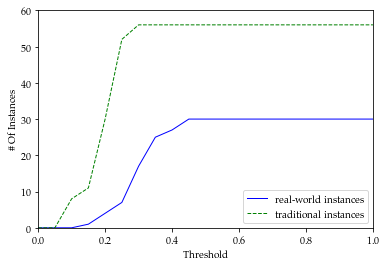

In [24]:
# Step 3: Threshold analysis
# 待选阈值的list
x = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]

threshold_len = len(x)
as_list = [0] * threshold_len
s_list = [0] * threshold_len
################################
total_instance_num = 86
as_num = 30
################
for i in range(total_instance_num):
    if i < as_num:
        csv_name = instance_name[i].replace('result/as/MOEAD/MOEAD_GLS/', '').replace('/PF/pf', '')
        data = pd.read_csv('threshold/' + csv_name + '-threshold.csv')
        y = data.iloc[:, 1]
        for j in range(threshold_len):
            if y[j] != 0:
                as_list[j] = as_list[j] + 1
    else:
        csv_name = instance_name[i].replace('result/s/MOEAD/MOEAD_GLS/', '').replace('/PF/pf', '')    
        data = pd.read_csv('threshold/' + csv_name + '-threshold.csv')
        y = data.iloc[:, 1]
        for j in range(threshold_len):
            if y[j] != 0:
                s_list[j] = s_list[j] + 1
print (as_list)
print (s_list)
l1, = plt.plot(x, as_list, 'b-', linestyle='-', linewidth=1)
l2, = plt.plot(x, s_list, 'g-', linestyle='--', linewidth=1)
plt.xlim(0, 1)
plt.ylim(0, 60)
plt.ylabel('\# Of Instances')
plt.xlabel('Threshold')
plt.legend(handles=[l1, l2], labels=['real-world instances', 'traditional instances'], loc='best')
# plt.savefig('step3.png')
plt.savefig('step3.eps', format='eps', dpi=1000)
plt.show()

In [25]:
# Plot asymmetric region map (distribution + frequency)
instance_name = []
instance_name.append('result/as/MOEAD/MOEAD_GLS/test50-0-0-0-0.d0.tw0.D4/PF/pf-0.1-3.csv')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test50-0-0-0-0.d0.tw0.D6/PF/pf-0.1-3.csv')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test50-0-0-0-0.d0.tw1.D4/PF/pf-0.1-3.csv')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test50-0-0-0-0.d0.tw1.D6/PF/pf-0.1-3.csv')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test50-0-0-0-0.d0.tw2.D4/PF/pf-0.1-3.csv')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test50-0-0-0-0.d0.tw2.D6/PF/pf-0.1-3.csv')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test50-0-0-0-0.d0.tw3.D4/PF/pf-0.1-3.csv')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test50-0-0-0-0.d0.tw3.D6/PF/pf-0.1-3.csv')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test50-0-0-0-0.d0.tw4.D4/PF/pf-0.1-3.csv')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test50-0-0-0-0.d0.tw4.D6/PF/pf-0.1-3.csv')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test150-0-0-0-0.d0.tw0.D4/PF/pf-0.1-3.csv')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test150-0-0-0-0.d0.tw0.D6/PF/pf-0.1-3.csv')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test150-0-0-0-0.d0.tw1.D4/PF/pf-0.1-3.csv')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test150-0-0-0-0.d0.tw1.D6/PF/pf-0.1-3.csv')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test150-0-0-0-0.d0.tw2.D4/PF/pf-0.1-3.csv')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test150-0-0-0-0.d0.tw2.D6/PF/pf-0.1-3.csv')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test150-0-0-0-0.d0.tw3.D4/PF/pf-0.1-3.csv')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test150-0-0-0-0.d0.tw3.D6/PF/pf-0.1-3.csv')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test150-0-0-0-0.d0.tw4.D4/PF/pf-0.1-3.csv')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test150-0-0-0-0.d0.tw4.D6/PF/pf-0.1-3.csv')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test250-0-0-0-0.d0.tw0.D4/PF/pf-0.1-3.csv')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test250-0-0-0-0.d0.tw0.D6/PF/pf-0.1-3.csv')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test250-0-0-0-0.d0.tw1.D4/PF/pf-0.1-3.csv')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test250-0-0-0-0.d0.tw1.D6/PF/pf-0.1-3.csv')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test250-0-0-0-0.d0.tw2.D4/PF/pf-0.1-3.csv')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test250-0-0-0-0.d0.tw2.D6/PF/pf-0.1-3.csv')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test250-0-0-0-0.d0.tw3.D4/PF/pf-0.1-3.csv')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test250-0-0-0-0.d0.tw3.D6/PF/pf-0.1-3.csv')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test250-0-0-0-0.d0.tw4.D4/PF/pf-0.1-3.csv')
instance_name.append('result/as/MOEAD/MOEAD_GLS/test250-0-0-0-0.d0.tw4.D6/PF/pf-0.1-3.csv')
data_sum = pd.read_csv(instance_name[0])
################################
as_num = 30
################
for i in range(1, as_num):
    print (instance_name[i])
    data = pd.read_csv(instance_name[i])
    data_sum = data_sum + data
data_sum = data_sum / as_num
print (data_sum)
data = pd.DataFrame(data_sum)
data.to_csv('as-distribution.csv', header=False, index=False)

frequency = np.zeros((8, 8))
for i in range(as_num):
    data = pd.read_csv(instance_name[i])
    # print (data)
    for c in range(8):
        column = data.iloc[:, c]
        # print (column)
        for r in range(8):
            if column[r] != 0:
                frequency[r][c] = frequency[r][c] + 1
print (frequency)
frequency = frequency / as_num
data = pd.DataFrame(frequency)
data.to_csv('as-frequency.csv', header=False, index=False)

result/as/MOEAD/MOEAD_GLS/test50-0-0-0-0.d0.tw0.D6/PF/pf-0.1-3.csv
result/as/MOEAD/MOEAD_GLS/test50-0-0-0-0.d0.tw1.D4/PF/pf-0.1-3.csv
result/as/MOEAD/MOEAD_GLS/test50-0-0-0-0.d0.tw1.D6/PF/pf-0.1-3.csv
result/as/MOEAD/MOEAD_GLS/test50-0-0-0-0.d0.tw2.D4/PF/pf-0.1-3.csv
result/as/MOEAD/MOEAD_GLS/test50-0-0-0-0.d0.tw2.D6/PF/pf-0.1-3.csv
result/as/MOEAD/MOEAD_GLS/test50-0-0-0-0.d0.tw3.D4/PF/pf-0.1-3.csv
result/as/MOEAD/MOEAD_GLS/test50-0-0-0-0.d0.tw3.D6/PF/pf-0.1-3.csv
result/as/MOEAD/MOEAD_GLS/test50-0-0-0-0.d0.tw4.D4/PF/pf-0.1-3.csv
result/as/MOEAD/MOEAD_GLS/test50-0-0-0-0.d0.tw4.D6/PF/pf-0.1-3.csv
result/as/MOEAD/MOEAD_GLS/test150-0-0-0-0.d0.tw0.D4/PF/pf-0.1-3.csv
result/as/MOEAD/MOEAD_GLS/test150-0-0-0-0.d0.tw0.D6/PF/pf-0.1-3.csv
result/as/MOEAD/MOEAD_GLS/test150-0-0-0-0.d0.tw1.D4/PF/pf-0.1-3.csv
result/as/MOEAD/MOEAD_GLS/test150-0-0-0-0.d0.tw1.D6/PF/pf-0.1-3.csv
result/as/MOEAD/MOEAD_GLS/test150-0-0-0-0.d0.tw2.D4/PF/pf-0.1-3.csv
result/as/MOEAD/MOEAD_GLS/test150-0-0-0-0.d0.tw2.D6/PF/pf

In [ ]:
# Plot symmetric region map (distribution + frequency)
instance_name = []
instance_name.append('result/s/MOEAD/MOEAD_GLS/C101_100/PF/pf-0.05-3.csv')
instance_name.append('result/s/MOEAD/MOEAD_GLS/C102_100/PF/pf-0.05-3.csv')
instance_name.append('result/s/MOEAD/MOEAD_GLS/C103_100/PF/pf-0.05-3.csv')
instance_name.append('result/s/MOEAD/MOEAD_GLS/C104_100/PF/pf-0.05-3.csv')
instance_name.append('result/s/MOEAD/MOEAD_GLS/C105_100/PF/pf-0.05-3.csv')
instance_name.append('result/s/MOEAD/MOEAD_GLS/C106_100/PF/pf-0.05-3.csv')
instance_name.append('result/s/MOEAD/MOEAD_GLS/C107_100/PF/pf-0.05-3.csv')
instance_name.append('result/s/MOEAD/MOEAD_GLS/C108_100/PF/pf-0.05-3.csv')
instance_name.append('result/s/MOEAD/MOEAD_GLS/C109_100/PF/pf-0.05-3.csv')
instance_name.append('result/s/MOEAD/MOEAD_GLS/C201_100/PF/pf-0.05-3.csv')
instance_name.append('result/s/MOEAD/MOEAD_GLS/C202_100/PF/pf-0.05-3.csv')
instance_name.append('result/s/MOEAD/MOEAD_GLS/C203_100/PF/pf-0.05-3.csv')
instance_name.append('result/s/MOEAD/MOEAD_GLS/C204_100/PF/pf-0.05-3.csv')
instance_name.append('result/s/MOEAD/MOEAD_GLS/C205_100/PF/pf-0.05-3.csv')
instance_name.append('result/s/MOEAD/MOEAD_GLS/C206_100/PF/pf-0.05-3.csv')
instance_name.append('result/s/MOEAD/MOEAD_GLS/C207_100/PF/pf-0.05-3.csv')
instance_name.append('result/s/MOEAD/MOEAD_GLS/C208_100/PF/pf-0.05-3.csv')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R101_100/PF/pf-0.05-3.csv')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R102_100/PF/pf-0.05-3.csv')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R103_100/PF/pf-0.05-3.csv')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R104_100/PF/pf-0.05-3.csv')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R105_100/PF/pf-0.05-3.csv')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R106_100/PF/pf-0.05-3.csv')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R107_100/PF/pf-0.05-3.csv')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R108_100/PF/pf-0.05-3.csv')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R109_100/PF/pf-0.05-3.csv')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R110_100/PF/pf-0.05-3.csv')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R111_100/PF/pf-0.05-3.csv')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R112_100/PF/pf-0.05-3.csv')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R201_100/PF/pf-0.05-3.csv')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R202_100/PF/pf-0.05-3.csv')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R203_100/PF/pf-0.05-3.csv')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R204_100/PF/pf-0.05-3.csv')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R205_100/PF/pf-0.05-3.csv')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R206_100/PF/pf-0.05-3.csv')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R207_100/PF/pf-0.05-3.csv')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R208_100/PF/pf-0.05-3.csv')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R209_100/PF/pf-0.05-3.csv')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R210_100/PF/pf-0.05-3.csv')
instance_name.append('result/s/MOEAD/MOEAD_GLS/R211_100/PF/pf-0.05-3.csv')

instance_name.append('result/s/MOEAD/MOEAD_GLS/RC101_100/PF/pf-0.05-3.csv')
instance_name.append('result/s/MOEAD/MOEAD_GLS/RC102_100/PF/pf-0.05-3.csv')
instance_name.append('result/s/MOEAD/MOEAD_GLS/RC103_100/PF/pf-0.05-3.csv')
instance_name.append('result/s/MOEAD/MOEAD_GLS/RC104_100/PF/pf-0.05-3.csv')
instance_name.append('result/s/MOEAD/MOEAD_GLS/RC105_100/PF/pf-0.05-3.csv')
instance_name.append('result/s/MOEAD/MOEAD_GLS/RC106_100/PF/pf-0.05-3.csv')
instance_name.append('result/s/MOEAD/MOEAD_GLS/RC107_100/PF/pf-0.05-3.csv')
instance_name.append('result/s/MOEAD/MOEAD_GLS/RC108_100/PF/pf-0.05-3.csv')
instance_name.append('result/s/MOEAD/MOEAD_GLS/RC201_100/PF/pf-0.05-3.csv')
instance_name.append('result/s/MOEAD/MOEAD_GLS/RC202_100/PF/pf-0.05-3.csv')
instance_name.append('result/s/MOEAD/MOEAD_GLS/RC203_100/PF/pf-0.05-3.csv')
instance_name.append('result/s/MOEAD/MOEAD_GLS/RC204_100/PF/pf-0.05-3.csv')
instance_name.append('result/s/MOEAD/MOEAD_GLS/RC205_100/PF/pf-0.05-3.csv')
instance_name.append('result/s/MOEAD/MOEAD_GLS/RC206_100/PF/pf-0.05-3.csv')
instance_name.append('result/s/MOEAD/MOEAD_GLS/RC207_100/PF/pf-0.05-3.csv')
instance_name.append('result/s/MOEAD/MOEAD_GLS/RC208_100/PF/pf-0.05-3.csv')

instance_num = 56
data_sum = pd.read_csv(instance_name[0])
for i in range(1, instance_num):
    print (instance_name[i])
    data = pd.read_csv(instance_name[i])
    data_sum = data_sum + data
data_sum = data_sum / instance_num
print (data_sum)
data = pd.DataFrame(data_sum)
data.to_csv('s-distribution.csv', header=False, index=False)

frequency = np.zeros((8, 8))
for i in range(instance_num):
    data = pd.read_csv(instance_name[i])
    # print (data)
    for c in range(8):
        column = data.iloc[:, c]
        # print (column)
        for r in range(8):
            if column[r] != 0:
                frequency[r][c] = frequency[r][c] + 1
print (frequency)
frequency = frequency / instance_num
data = pd.DataFrame(frequency)
data.to_csv('s-frequency.csv', header=False, index=False)                

In [ ]:
ins = 'result/as/MOEAD/MOEAD_GLS/test150-0-0-0-0.d0.tw4.D6/PF/pf'
kcc = KCC(ins, False)
kcc.scatter_plot()
ins = 'result/as/MOEAD/MOEAD_GLS/test250-0-0-0-0.d0.tw4.D6/PF/pf'
kcc = KCC(ins, False)
kcc.scatter_plot()
ins = 'result/s/MOEAD/MOEAD_GLS/C204_100/PF/pf'
kcc = KCC(ins, True)
kcc.scatter_plot()
ins = 'result/s/MOEAD/MOEAD_GLS/R101_100/PF/pf'
kcc = KCC(ins, True)
kcc.scatter_plot()